# JaCoCo Visualization

In [9]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

jacoco_path = '../../generated/code-analysis/jacoco.csv'

if not os.path.exists(jacoco_path):
    raise FileNotFoundError(f"Le fichier JaCoCo n'existe pas : {jacoco_path}. Exécutez le notebook 'notebooks/arrange data/JaCoCo.ipynb' pour le générer.")

out_jacoco_path = '../../generated/figures/jacoco'
if not os.path.exists(out_jacoco_path):
    os.makedirs(out_jacoco_path)

df_jacoco = pd.read_csv(jacoco_path)
cols = ['instruction', 'branch', 'line', 'method']

# Effet d'ordre

In [10]:
from notebooks.analysis import tests

results = []
alpha = 0.05

for metric in cols:
    pivot = df_jacoco.pivot(index='user', columns='game_mode', values=metric)
    pivot = pivot.dropna()

    groups = df_jacoco.drop_duplicates('user')[['user', 'group']]
    pivot = pivot.merge(groups.set_index('user'), left_index=True, right_index=True)

    pivot['diff'] = pivot.apply(
        lambda row: row['leaderboard'] - row['achievements'] if row['group'] == 'A'
                    else row['achievements'] - row['leaderboard'],
        axis=1
    )

    group_a = pivot[pivot['group'] == 'A']['diff']
    group_b = pivot[pivot['group'] == 'B']['diff']

    assert len(group_a) == len(group_b), f"Mismatch in sample size for {metric}"

    # Test de normalité
    _, p_normal_diff_a = stats.shapiro(group_a)
    _, p_normal_diff_b = stats.shapiro(group_b)

    # Test variance
    stat, variance_p_value = stats.levene(group_a, group_b)

    # Choix du test
    if p_normal_diff_a > 0.05 and p_normal_diff_b > 0.05:
        t_stat, p_value = stats.ttest_ind(group_a, group_b, equal_var=True)
        test = "t-test"
    else:
        t_stat, p_value = stats.mannwhitneyu(group_a, group_b)
        test = "Wilcoxon"

    a12 = tests.vargha_delaney_a12(group_a, group_b)

    results.append([
        metric.capitalize(),
        p_normal_diff_a > 0.05,
        p_normal_diff_b > 0.05,
        variance_p_value > 0.05,
        test,
        p_value,
        p_value < alpha,
        a12,
        tests.a12_label(a12)
    ])

order_effect_df = pd.DataFrame(results, columns=[
    'metric',
    'a_normal',
    'b_normal',
    'variance_equals',
    'test',
    'p_value',
    'significant',
    'vargha_delaney_a12',
    'vargha_delaney'
])

order_effect_df

,metric,a_normal,b_normal,variance_equals,test,p_value,significant,vargha_delaney_a12,vargha_delaney
0,Instruction,False,True,True,Wilcoxon,0.573737,False,0.406250,Effet faible
1,Branch,False,True,True,Wilcoxon,1.000000,False,0.492188,Aucun effet
2,Line,True,True,True,t-test,0.700130,False,0.515625,Aucun effet
3,Method,True,True,True,t-test,0.813933,False,0.546875,Aucun effet


In [11]:
order_effect_df_count = len(order_effect_df[order_effect_df['significant'] == True])
if order_effect_df_count > 0:
    print(f"Il y a {order_effect_df_count} un effet d'ordre.")
else:
    print("Aucun effet d'ordre.")

Aucun effet d'ordre.


# Effet de session

In [12]:
from notebooks.analysis import tests

results = []
alpha = 0.05

for metric in cols:
    df_rounds = df_jacoco.copy()
    df_rounds['round'] = df_rounds.groupby('user').cumcount() + 1

    # Comparer les performances au round 1 vs round 2
    session1 = df_rounds[df_rounds['session'] == 1][metric]
    session2 = df_rounds[df_rounds['session'] == 2][metric]

    assert len(session1) == len(session2), f"Mismatch in sample size for {metric}"

    # Normalité ?
    _, p_shapiro_1 = stats.shapiro(session1)
    _, p_shapiro_2 = stats.shapiro(session2)

    # Test variance
    stat, variance_p_value = stats.levene(session1, session2)

    if p_shapiro_1 > 0.05 and p_shapiro_2 > 0.05:
        t_stat, p_value = stats.ttest_rel(session1, session2)  # si apparié
        test = "t-test"
    else:
        t_stat, p_value = stats.wilcoxon(session1, session2)
        test = "Wilcoxon"


    a12 = tests.vargha_delaney_a12(session1, session2)

    results.append([
        metric.capitalize(),
        p_shapiro_1 > 0.05,
        p_shapiro_2 > 0.05,
        variance_p_value > 0.05,
        test,
        p_value,
        p_value < alpha,
        a12,
        tests.a12_label(a12)
    ])

session_effect_df = pd.DataFrame(results, columns=[
    'metric',
    'a_normal',
    'b_normal',
    'variance_equals',
    'test',
    'p_value',
    'significant',
    'vargha_delaney_a12',
    'vargha_delaney'
])

session_effect_df

,metric,a_normal,b_normal,variance_equals,test,p_value,significant,vargha_delaney_a12,vargha_delaney
0,Instruction,False,True,True,Wilcoxon,0.596588,False,0.451172,Aucun effet
1,Branch,False,True,True,Wilcoxon,0.082931,False,0.376953,Effet moyen
2,Line,False,True,True,Wilcoxon,0.569430,False,0.492188,Aucun effet
3,Method,False,True,True,Wilcoxon,0.795820,False,0.505859,Aucun effet


In [13]:
session_effect_df_count = len(session_effect_df[session_effect_df['significant'] == True])
if session_effect_df_count > 0:
    print(f"Il y a {session_effect_df_count} un effet d'ordre.")
else:
    print("Aucun effet d'ordre.")

Aucun effet d'ordre.


# Meilleur mode

In [14]:
from notebooks.analysis import tests

results = []
alpha = 0.05

for metric in cols:
    leaderboard = df_jacoco[df_jacoco['game_mode'] == 'leaderboard'][metric].values.flatten()
    achievements = df_jacoco[df_jacoco['game_mode'] == 'achievements'][metric].values.flatten()

    assert len(leaderboard) == len(achievements), f"Mismatch in sample size for {metric}"

    # Test de normalité
    _, p_normal_diff_leaderboard = stats.shapiro(leaderboard)
    _, p_normal_diff_achievements = stats.shapiro(achievements)

    # Test variance
    stat, variance_p_value = stats.levene(leaderboard, achievements)

    # Choix du test
    if p_normal_diff_leaderboard > 0.05 and p_normal_diff_achievements > 0.05:
        t_stat, p_value = stats.ttest_ind(leaderboard, achievements, equal_var=True)
        test = "t-test"
    else:
        t_stat, p_value = stats.mannwhitneyu(leaderboard, achievements)
        test = "Mann-Whitney U"

    a12 = tests.vargha_delaney_a12(leaderboard, achievements)
    a12_label = tests.a12_label(a12)
    better_mode = "eaquals" if a12 == 0.5 else "leaderboard" if a12 > 0.5 else "achievements"

    results.append([
        metric.capitalize(),
        p_normal_diff_leaderboard > 0.05,
        p_normal_diff_achievements > 0.05,
        variance_p_value > 0.05,
        test,
        p_value,
        p_value < alpha,
        a12,
        a12_label,
        better_mode
    ])

best_mode_df = pd.DataFrame(results, columns=[
    'metric',
    'leaderboard_normal',
    'achievements_normal',
    'variance_equals',
    'test',
    'p_value',
    'significant',
    'vargha_delaney_a12',
    'vargha_delaney',
    'better_mode',
])

best_mode_df

,metric,leaderboard_normal,achievements_normal,variance_equals,test,p_value,significant,vargha_delaney_a12,vargha_delaney,better_mode
0,Instruction,False,False,True,Mann-Whitney U,0.584281,False,0.441406,Aucun effet,achievements
1,Branch,False,False,True,Mann-Whitney U,1.000000,False,0.500000,Aucun effet,eaquals
2,Line,True,False,True,Mann-Whitney U,0.924788,False,0.511719,Aucun effet,leaderboard
3,Method,True,False,True,Mann-Whitney U,0.776974,False,0.531250,Aucun effet,leaderboard


# Graphiques

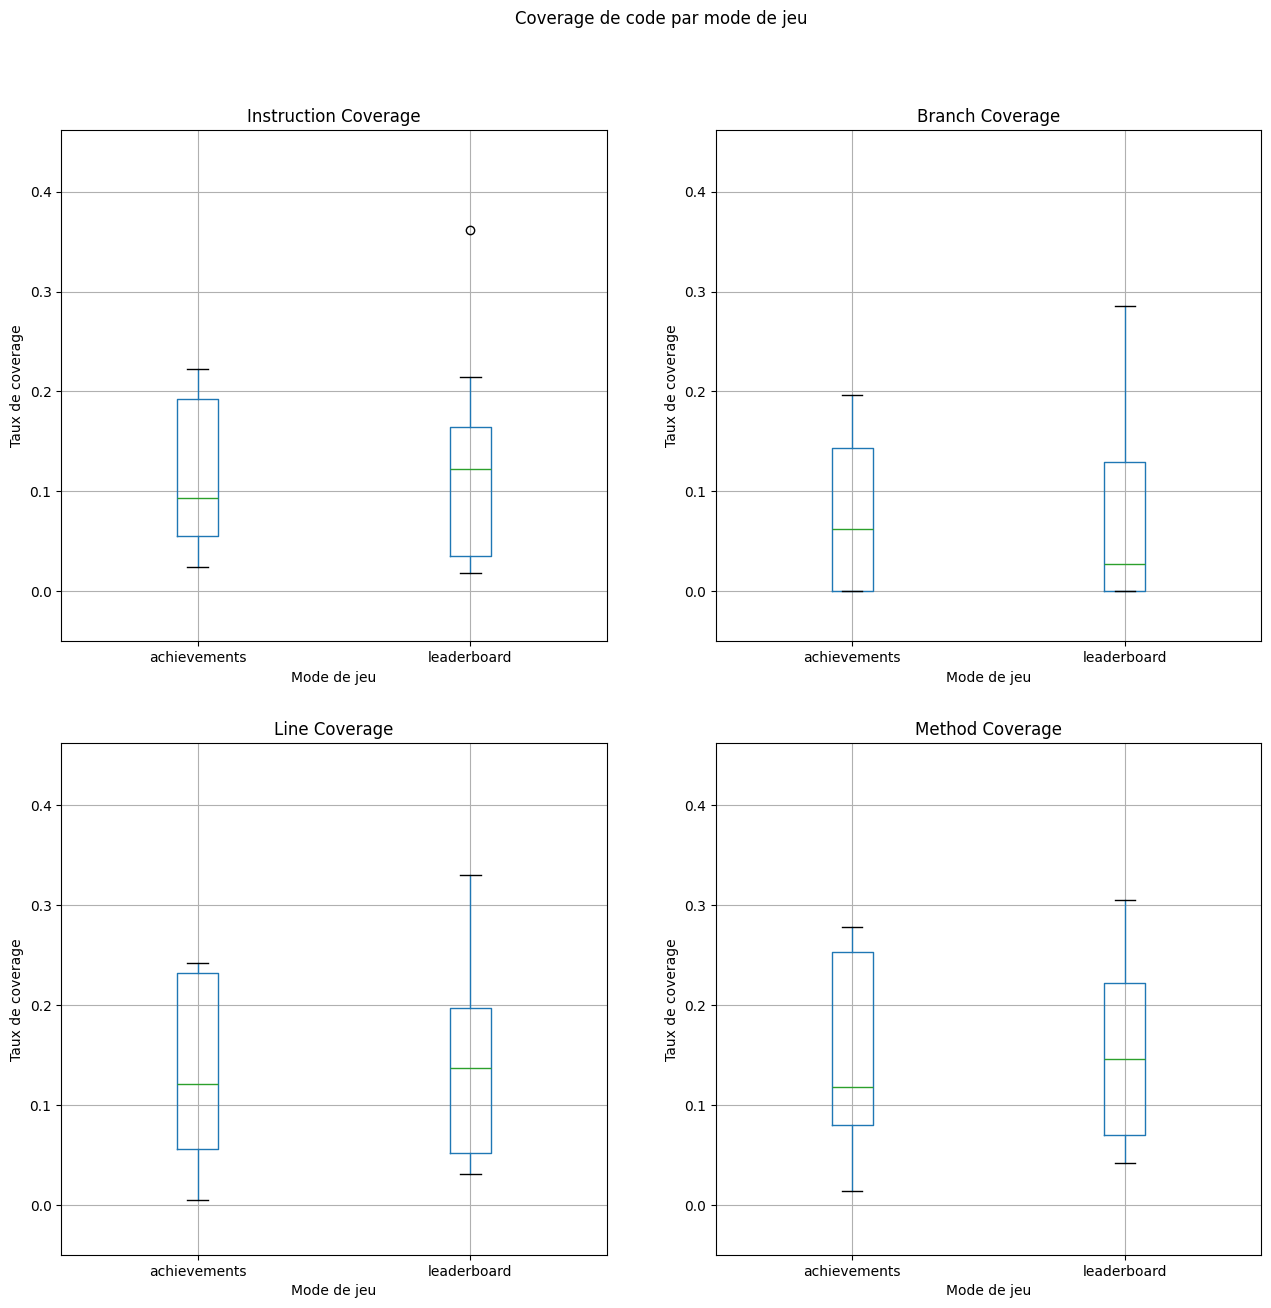

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.ravel()

y_max = df_jacoco[cols].max().max() + 0.1

for i, metric in enumerate(cols):
    ax = axs[i]
    bp = df_jacoco.boxplot(column=metric, by='game_mode', ax=ax)
    ax.set_title(f'{metric.capitalize()} Coverage')
    ax.set_ylabel('Taux de coverage')
    ax.set_xlabel('Mode de jeu')
    ax.grid(True)
    ax.set_ylim(-0.05, y_max)

plt.suptitle('Coverage de code par mode de jeu')
plt.savefig(f"{out_jacoco_path}/coverage_by_game_mode.pdf")
plt.show()

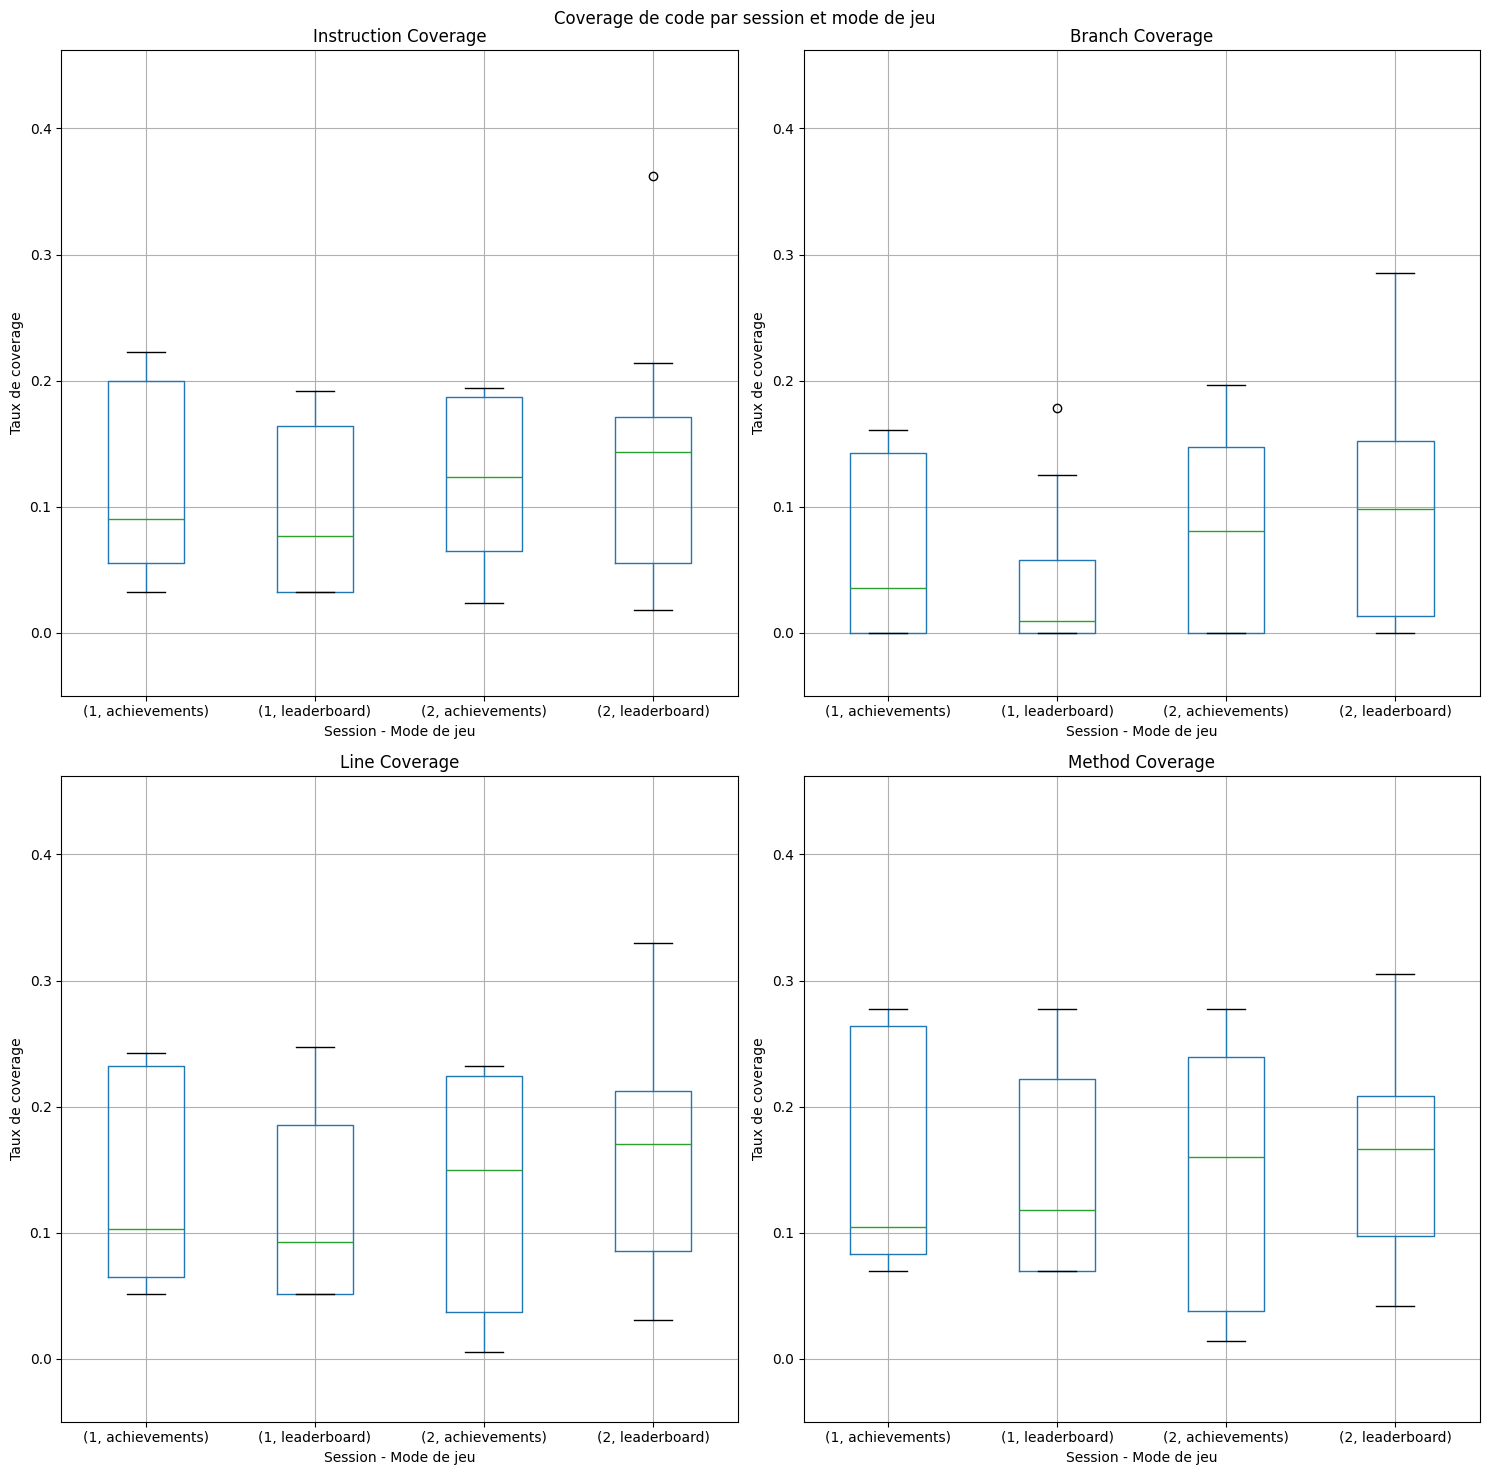

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.ravel()

y_max = df_jacoco[cols].max().max() + 0.1

for i, metric in enumerate(cols):
    ax = axs[i]

    # Boxplot par session
    df_jacoco.boxplot(column=metric, by=['session', 'game_mode'], ax=ax)
    ax.set_title(f'{metric.capitalize()} Coverage')
    ax.set_ylabel('Taux de coverage')
    ax.set_xlabel('Session - Mode de jeu')
    ax.grid(True)
    ax.set_ylim(-0.05, y_max)
    ax.tick_params(axis='x', rotation=0)

plt.suptitle('Coverage de code par session et mode de jeu')
plt.tight_layout()
plt.savefig(f"{out_jacoco_path}/coverage_by_session_and_game_mode.pdf")
plt.show()
